In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests
#from Preprocessing import clean_text, remove_names, entity_recognizing, remove_url
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from keras import Sequential
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import LSTM
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.regularizers import l2
import re
import os

%matplotlib inline
print(tf.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
2.4.1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Section

In [24]:
path = "drive/MyDrive/IAS/Semester3/NLP/data/fox_news.csv"
df_training = pd.read_csv(path)
df_training = df_training.rename(columns={'class': 'label'})
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3056 entries, 0 to 3055
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3056 non-null   int64 
 1   text        3056 non-null   object
 2   label       3056 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 71.8+ KB


In [5]:
df_training['label'].value_counts()


0    2186
1     870
Name: label, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b93a832b0>],
      dtype=object)

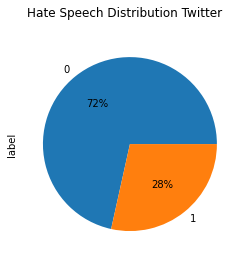

In [22]:
df_training.label.value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%', title='Hate Speech Distribution Twitter')


## class = class label for Fox news. 1 - hate speech 0 - non hate

In [ ]:
# df_training = df_training[['class','tweet']]
# df_training.replace({'class' : { 0 : 1, 1 : 0, 2 : 0 }},inplace=True)
# df_training['class'].value_counts()

In [ ]:
def filter_hatespeech_texts(df):
    
    def filter_texts(text):
        return re.sub('@.\:|!|@\w+:|@[\w]*|&#[0-9]*;|#\w+|RT|\/\/t.co\/\w+|&gt|&lt', '', text)

    def postprocess_filter_texts(text):
        
        return df

    df['text'] = df['text'].apply(filter_texts)
    df.replace("", np.nan, inplace=True)
    df = df.dropna()
    
    
    return df

df_training = filter_hatespeech_texts(df_training)

In [ ]:
TEXT_COLUMN = "text"
LABEL_COLUMN = "label"

print("Converting to lower-case")
df_training[TEXT_COLUMN] = df_training[TEXT_COLUMN].str.lower()
print(df_training.head())

Converting to lower-case
   Unnamed: 0                                               text  label
0           0            barryswallows merkel would never say no      1
1           1  postapocalyptichero expect more and more women...      1
2           2  californiamojo groping people in public wasn't...      0
3           3  mikeste merkel, possible the only person in ch...      1
4           4  scientist they know very well, no means no the...      1


In [ ]:
df_training['doc_len'] = df_training[TEXT_COLUMN].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(df_training['doc_len'].mean() + df_training['doc_len'].std()).astype(int)

In [ ]:
df_training.head()

,Unnamed: 0,text,label,doc_len
0,0,barryswallows merkel would never say no,1,6
1,1,postapocalyptichero expect more and more women...,1,29
2,2,californiamojo groping people in public wasn't...,0,13
3,3,"mikeste merkel, possible the only person in ch...",1,82
4,4,"scientist they know very well, no means no the...",1,21


## Splitting the data

In [ ]:
seed = 11
test_size = 0.2
# categories = ['not hate speech', 'hate speech]
categories = [0,1]
def split_dataset(df, seed, test_size):
    train, test = train_test_split(df, test_size=test_size, random_state=seed, shuffle=True)
    return train.text, train.label, test.text, test.label

In [ ]:
train, train_targets, test, test_targets = split_dataset(df_training, seed=seed, test_size=test_size)

In [ ]:
train_targets.values

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
def calculate_dataset_class_distribution(targets, categories):
    df = pd.DataFrame({'category':targets})
    s = df.category.value_counts(normalize=True)
    s = s.reindex(categories)
    return [s.index[0], s[0]], [s.index[1], s[1]]

In [ ]:
train_class_distribution = calculate_dataset_class_distribution(train_targets, categories)
test_class_distribution = calculate_dataset_class_distribution(test_targets, categories)

In [ ]:
embed_size = 300  # how big is each word vector
max_features = None  # how many unique words to use (i.e num rows in embedding vector)
maxlen = max_seq_len  # max number of words in a question to use #99.99%

def encode(data, label):
    # fill up the missing values
    X = data.fillna("_na_").values
    total_texts = df_training.text.fillna("_na_").values
    
    # Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features, filters='')
    tokenizer.fit_on_texts(list(total_texts))
    X = tokenizer.texts_to_sequences(X)
    vocab_size = len(tokenizer.word_index) + 1
    print(tokenizer.word_index)
    
    # Pad the sentences
    X = pad_sequences(X, maxlen=maxlen)
    print(X.shape)
    
    # Get the target values
    y = pd.get_dummies(label.values)
    print(y.shape)
    #le = LabelEncoder()
    #le.fit(Y_train)
    #encoded_Y = le.transform(Y_train)
    return X,y,vocab_size
    

In [ ]:
# FETCH DATA, LABELS, DICTIONARIES
X_train, y_train, vocab_size = encode(train, train_targets)
X_test, y_test, vocab_size = encode(test, test_targets)

print(vocab_size)

{'the': 1, 'to': 2, 'and': 3, 'a': 4, 'of': 5, 'is': 6, 'in': 7, 'that': 8, 'you': 9, 'i': 10, 'are': 11, 'for': 12, 'it': 13, 'they': 14, 'not': 15, 'have': 16, 'be': 17, 'with': 18, 'on': 19, 'this': 20, 'as': 21, 'was': 22, 'people': 23, 'who': 24, 'all': 25, 'your': 26, 'will': 27, 'their': 28, 'or': 29, 'what': 30, 'but': 31, 'if': 32, 'no': 33, 'so': 34, 'just': 35, 'we': 36, 'do': 37, 'by': 38, 'has': 39, 'like': 40, 'from': 41, 'an': 42, 'at': 43, 'can': 44, 'he': 45, 'would': 46, 'about': 47, 'get': 48, 'she': 49, 'should': 50, "don't": 51, 'one': 52, 'them': 53, 'there': 54, 'because': 55, 'more': 56, 'out': 57, 'up': 58, 'than': 59, 'how': 60, "it's": 61, 'only': 62, 'my': 63, 'our': 64, 'when': 65, 'his': 66, 'any': 67, 'why': 68, 'white': 69, 'obama': 70, 'some': 71, 'make': 72, 'these': 73, 'her': 74, 'then': 75, 'been': 76, 'want': 77, 'were': 78, 'never': 79, 'those': 80, 'think': 81, 'wayne230': 82, 'know': 83, 'many': 84, 'did': 85, 'after': 86, 'country': 87, 'need':

In [ ]:
y_train

,0,1
0,1,0
1,0,1
2,1,0
3,1,0
4,0,1
...,...,...
2439,1,0
2440,1,0
2441,1,0
2442,1,0


## Creating the model

In [ ]:
# model = Sequential()
# model.add(Embedding(vocab_size, embed_size, input_length=X_train.shape[1]))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 4
batch_size = 32
lr = 0.001


model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embed_size, input_length=X_train.shape[1]),
        tf.keras.layers.LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        tf.keras.layers.Dense(2, activation = 'softmax')
  ])

model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=lr),
                loss='categorical_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 63, 300)           2655900   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 2,749,470
Trainable params: 2,749,470
Non-trainable params: 0
_________________________________________________________________


In [ ]:


#history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

history = model.fit(X_train, y_train, 
      epochs=epochs,  
      verbose=1, 
      validation_split=0.25,
      batch_size=batch_size)

Epoch 1/4
58/58 [==============================] - 11s 148ms/step - loss: 3.6196 - accuracy: 0.7110 - precision: 0.7110 - recall: 0.7110 - val_loss: 1.6727 - val_accuracy: 0.7218 - val_precision: 0.7218 - val_recall: 0.7218
Epoch 2/4
58/58 [==============================] - 8s 134ms/step - loss: 1.3936 - accuracy: 0.7562 - precision: 0.7562 - recall: 0.7562 - val_loss: 1.0212 - val_accuracy: 0.8429 - val_precision: 0.8429 - val_recall: 0.8429
Epoch 3/4
58/58 [==============================] - 7s 125ms/step - loss: 0.7444 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - val_loss: 0.8201 - val_accuracy: 0.8871 - val_precision: 0.8871 - val_recall: 0.8871
Epoch 4/4
58/58 [==============================] - 7s 123ms/step - loss: 0.5616 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - val_loss: 0.7277 - val_accuracy: 0.9018 - val_precision: 0.9018 - val_recall: 0.9018


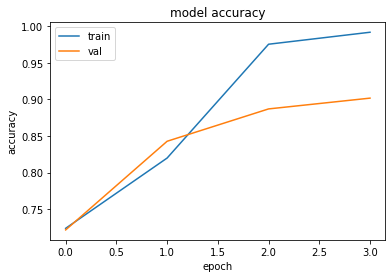

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

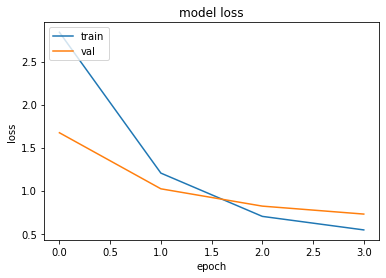

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test,batch_size=32)
print("loss: %s accuracy: %s precision: %s recall: %s" % (loss, accuracy, precision, recall))


20/20 [==============================] - 0s 19ms/step - loss: 0.7717 - accuracy: 0.8856 - precision: 0.8856 - recall: 0.8856
loss: 0.7717276215553284 accuracy: 0.8856208920478821 precision: 0.8856208920478821 recall: 0.8856208920478821


In [ ]:
Y_pred = model.predict(X_test)


In [ ]:
Y_pred

array([[0.96836656, 0.03163341],
       [0.06555072, 0.93444926],
       [0.9824568 , 0.01754324],
       ...,
       [0.97919446, 0.02080559],
       [0.0362583 , 0.96374166],
       [0.99655163, 0.00344836]], dtype=float32)

In [ ]:
Y_pred = np.argmax(Y_pred, axis=1)
Y_pred

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,

In [ ]:
categories = ['not hate speech', 'hate speech']
 
report = classification_report(test_targets.values, Y_pred, target_names=categories, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
not hate speech,0.883929,0.956522,0.918794,414.000000
hate speech,0.890244,0.737374,0.806630,198.000000
accuracy,0.885621,0.885621,0.885621,0.885621
macro avg,0.887086,0.846948,0.862712,612.000000
weighted avg,0.885972,0.885621,0.882505,612.000000


In [ ]:
name = 'drive/MyDrive/IAS/Semester3/NLP/matrix_report_lstm_FoxNews.csv'
df_report.to_csv(name)

In [ ]:
df_results = pd.DataFrame(history.history)
df_results['learning_rate'] = lr
df_results['num_epochs'] = epochs
df_results['batch_size'] = batch_size
df_results['num_classes'] =  len(categories) 
df_results['test_size'] = test_size
df_results['train_size'] = len(train)
df_results['seed'] = seed
df_results['test_size'] = len(test)
df_results['train_class_proportion_' + categories[0]] = round(train_class_distribution[0][1], 2)
df_results['train_class_proportion_' + categories[1]] = round(train_class_distribution[1][1], 2)
df_results['test_class_proportion_' + categories[0]] = round(test_class_distribution[0][1], 2)
df_results['test_class_proportion_' + categories[1]] = round(test_class_distribution[1][1], 2)

In [ ]:
df_results.head()

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,learning_rate,num_epochs,batch_size,num_classes,test_size,train_size,seed,train_class_proportion_not hate speech,train_class_proportion_hate speech,test_class_proportion_not hate speech,test_class_proportion_hate speech
0,2.840448,0.723950,0.723950,0.723950,1.672694,0.721768,0.721768,0.721768,0.001,4,32,2,612,2444,11,0.73,0.27,0.68,0.32
1,1.203758,0.819967,0.819967,0.819967,1.021236,0.842881,0.842881,0.842881,0.001,4,32,2,612,2444,11,0.73,0.27,0.68,0.32
2,0.700909,0.975450,0.975450,0.975450,0.820104,0.887070,0.887070,0.887070,0.001,4,32,2,612,2444,11,0.73,0.27,0.68,0.32
3,0.543640,0.991817,0.991817,0.991817,0.727678,0.901800,0.901800,0.901800,0.001,4,32,2,612,2444,11,0.73,0.27,0.68,0.32


In [ ]:
name = 'drive/MyDrive/IAS/Semester3/NLP/training_logs_lstm_FoxNews.csv'
df_results.to_csv(name)

In [ ]:
def plot_loss(path, ax, title):
    df = pd.read_csv(path)
    df.loss.plot(kind='line', legend=True, title=title, ax=ax, figsize=(15,8))
    ax.legend(loc='upper right')
    plt.xlabel('Step') 
    plt.ylabel('Loss')

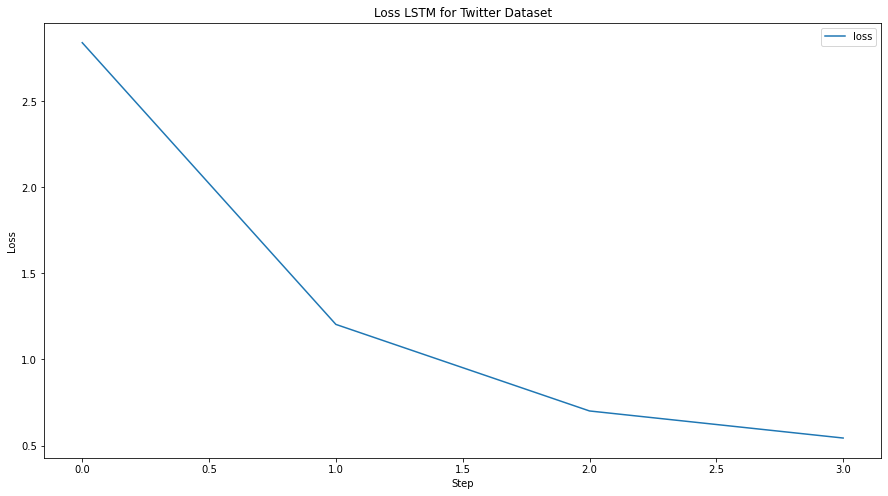

In [ ]:
fig, axs = plt.subplots(1,1)
path = 'drive/MyDrive/IAS/Semester3/NLP/training_logs_lstm_FoxNews.csv'
plot_loss(path, axs, title='Loss LSTM for Twitter Dataset')

## Classication of Movies

### Load Movies

In [ ]:
def read_movie_files(pathes):
    result = []
    for path in pathes: 
        directory = os.fsencode(path)

        for file in os.listdir(directory):
            filename = os.fsdecode(file)

            if filename.endswith(".csv"):
                #print(os.path.join(directory, filename))
                #local_df = read_content(path + '//' + filename)
                movie_df = pd.read_csv(path + '//' + filename)
                tag = path.split('/')[-1]
                count_utterances = movie_df.shape[0]
                result.append({'movie_name': filename[:-9], 'count_utterances': count_utterances, 'tag': tag, 'path': path + '//' + filename})
    result_df = pd.DataFrame(result)
    return result_df

In [ ]:
pathes = ['drive/MyDrive/IAS/Semester3/NLP/movies/racism', 'drive/MyDrive/IAS/Semester3/NLP/movies/hate_speech', 'drive/MyDrive/IAS/Semester3/NLP/movies/friendship']

In [ ]:
movie_metadata_df = read_movie_files(pathes)
movie_metadata_df.head()

,movie_name,count_utterances,tag,path
0,A Time to Kill,2219,racism,drive/MyDrive/IAS/Semester3/NLP/movies/racism/...
1,Apocalypse Now,2070,racism,drive/MyDrive/IAS/Semester3/NLP/movies/racism/...
2,Amistad,1124,racism,drive/MyDrive/IAS/Semester3/NLP/movies/racism/...
3,Bad Boys II,2394,racism,drive/MyDrive/IAS/Semester3/NLP/movies/racism/...
4,Angel Heart,910,racism,drive/MyDrive/IAS/Semester3/NLP/movies/racism/...


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba2dc2af98>],
      dtype=object)

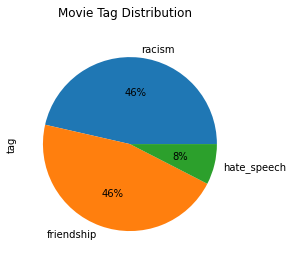

In [ ]:
movie_metadata_df.tag.value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%', title='Movie Tag Distribution')

In [ ]:
path = 'drive/MyDrive/IAS/Semester3/NLP/data/all_movies.csv'
all_movie_data = pd.read_csv(path, index_col=0)

In [ ]:
all_movie_data.head()

,movie_name,index,utterance,count_utterances,tag
0,12 Angry Men,0,"Thank you very much, sir.",2065,racism
1,12 Angry Men,1,You did a wonderful job. Wonderful.,2065,racism
2,12 Angry Men,2,Shh. Shh.,2065,racism
3,12 Angry Men,3,"We did it, Pete. We did it.",2065,racism
4,12 Angry Men,4,"For a moment, we had our doubts.",2065,racism


In [ ]:
def annotate_single_movie(movie_df):
    utterances = movie_df.dialog.values
    predictions = []
    batch = []
    #doc_len = movie_df.dialog.apply(lambda words: len(words.split(" ")))
    #max_seq_len = np.round(doc_len.mean() + doc_len.std()).astype(int)
    # Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features, filters='')
    tokenizer.fit_on_texts(utterances)


 
    utterances = tokenizer.texts_to_sequences(utterances)
    # Pad the sentences
    utterances = pad_sequences(utterances, maxlen=maxlen)
    #print(utterances.shape)
    vocab_size = len(tokenizer.word_index) + 1
    #print(tokenizer.word_index)
    

    predictions = model.predict(utterances)
    predictions = np.argmax(predictions, axis=1)
    #print(predictions)


    result = []
    
    for i, pred in enumerate(predictions):
        result.append({'index': i, 'label_LSTM_FoxNews': categories[pred]})
    
    result_df = pd.DataFrame(result)
    movie_df = movie_df.merge(result_df, right_index=True, left_index=True)
    
    del movie_df['Unnamed: 0']
    del movie_df['index']

    return movie_df
    

## Annotate Movies

In [ ]:
movie_df = pd.read_csv(pathes[0]+'/12 Angry Men_conv.csv')

In [ ]:
movie_df.head()

,Unnamed: 0,dialog
0,0,"Thank you very much, sir."
1,1,You did a wonderful job. Wonderful.
2,2,Shh. Shh.
3,3,"We did it, Pete. We did it."
4,4,"For a moment, we had our doubts."


In [ ]:
annotate_single_movie(movie_df)

,dialog,label_LSTM_twitter
0,"Thank you very much, sir.",not hate speech
1,You did a wonderful job. Wonderful.,not hate speech
2,Shh. Shh.,not hate speech
3,"We did it, Pete. We did it.",not hate speech
4,"For a moment, we had our doubts.",not hate speech
...,...,...
2060,What's your name?,not hate speech
2061,Davis.,not hate speech
2062,My name's McCardle.,not hate speech
2063,"Well, so long.",not hate speech


In [ ]:
def movie_data_cleansing(df):
    df = df.replace(r'<[^\\]>', '', regex=True)
    df = df.replace(r'<\\.*>', '', regex=True)
    return df

In [ ]:
def annotate_movies(movie_metadata_df):
    
    pathes = movie_metadata_df.path.values
    tags = movie_metadata_df.tag.values
    movie_names = movie_metadata_df.movie_name.values
    
    result = []
    for i in range(0, movie_metadata_df.shape[0]):
        path = pathes[i]
        tag = tags[i]
        movie_name = movie_names[i]
        print(i+1, movie_metadata_df.shape[0], path, tag, movie_name)
        movie_df = pd.read_csv(path)
        movie_df = movie_data_cleansing(movie_df)
        movie_df = movie_data_cleansing(movie_df)
        movie_df = annotate_single_movie(movie_df)
        
        labels = movie_df.label_LSTM_twitter.values
                
        for i in range(0, len(labels)):
            result.append({'movie_name': movie_name, 'index': i, 'label': labels[i]})
                    
    result_df = pd.DataFrame(result)     
    return result_df

In [ ]:
movies_annotated_df = annotate_movies(movie_metadata_df)

1 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//A Time to Kill_conv.csv racism A Time to Kill
2 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Apocalypse Now_conv.csv racism Apocalypse Now
3 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Amistad_conv.csv racism Amistad
4 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Bad Boys II_conv.csv racism Bad Boys II
5 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Angel Heart_conv.csv racism Angel Heart
6 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Bone Tomahawk_conv.csv racism Bone Tomahawk
7 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Enter the Dragon_conv.csv racism Enter the Dragon
8 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Dragged Across Concrete_conv.csv racism Dragged Across Concrete
9 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Antebellum_conv.csv racism Antebellum
10 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Empire of the Sun_conv.csv racism Empire of the Sun
11 252 drive/MyDr

In [ ]:
movies_annotated_df.to_csv('drive/MyDrive/IAS/Semester3/NLP/annotations/annotations_LSTM_FoxNews.csv')